In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def run_kn(X_train, Y_train, X_test, Y_test):
    '''run KNeighbors wit CV.

    return: predictions, r2, MSE.
    '''
    params_kn = {'n_neighbors':list(np.arange(20, 50, 2))}
    kn = KNeighborsRegressor()
    gs = GridSearchCV(kn, param_grid=params_kn, cv=3, scoring='neg_mean_squared_error')
    gs.fit(X_train, Y_train)
    Y_pred = gs.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    return (Y_pred, mse, r2, gs)

def run_rf(X_train, Y_train, X_test, Y_test):
    '''run Randomforest wit CV.

    return: predictions, r2, MSE.
    '''
    params_rf = {'n_estimators':list(np.arange(50, 200, 50)), 'max_depth':list(np.arange(3, 10, 3)) }
    rf = RandomForestRegressor(random_state = 1)
    gs = GridSearchCV(rf, param_grid=params_rf, cv=3, scoring='neg_mean_squared_error')
    gs.fit(X_train, Y_train)
    Y_pred = gs.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    return (Y_pred, mse, r2, gs)

def block_sampling(N, k, l):
    '''select k distinct intervals of size l from 0 to N

    return: a boolean series of length N.
    '''
    seq = list(range(N))
    indices = range(N - (l - 1) * k)
    result = np.array([False] * N)
    offset = 0
    for i in sorted(np.random.choice(indices, k)):
        i += offset
        result[seq[i:i+l]] = 1
        offset += l - 1
    return result

## Load data aggregate by hour

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('energydata_complete.csv', parse_dates = ["date"], date_parser=dateparse, index_col = "date")  
hour, day = data.index.hour, data.index.date
data["hour"] = hour
data["day"] = day
data_A = data.groupby(["day", 'hour']).mean()
del data_A['rv1'], data_A['rv2']
N = len(data_A)
data_A.head()

Appliances     lights         T1       RH_1         T2  \
day        hour                                                           
2016-01-11 17     55.000000  35.000000  19.890000  46.502778  19.200000   
           18    176.666667  51.666667  19.897778  45.879028  19.268889   
           19    173.333333  25.000000  20.495556  52.805556  19.925556   
           20    125.000000  35.000000  20.961111  48.453333  20.251111   
           21    103.333333  23.333333  21.311667  45.768333  20.587778   

                      RH_2         T3       RH_3         T4       RH_4  ...  \
day        hour                                                         ...   
2016-01-11 17    44.626528  19.790000  44.897778  18.932778  45.738750  ...   
           18    44.438889  19.770000  44.863333  18.908333  46.066667  ...   
           19    46.061667  20.052222  47.227361  18.969444  47.815556  ...   
           20    45.632639  20.213889  47.268889  19.190833  49.227917  ...   
           21    44.961111  20.373333  46.164444  19.425556  47.918889  ...   

                        T8       RH_8         T9       RH_9     T_out  \
day        hour                                                         
2016-01-11 17    18.150000  48.710556  17.016667  45.446667  6.308333   
           18    18.094444  48.597222  16.981667  45.290000  5.941667   
           19    18.156111  49.213333  16.902222  45.311389  6.000000   
           20    18.773333  50.195556  16.890000  45.118889  6.000000   
           21    19.153333  49.542222  16.890000  44.807778  5.833333   

                 Press_mm_hg     RH_out  Windspeed  Visibility  Tdewpoint  
day        hour                                                            
2016-01-11 17     733.750000  92.000000   6.166667   53.416667   5.050000  
           18     734.266667  91.583333   5.416667   40.000000   4.658333  
           19     734.791667  89.750000   6.000000   40.000000   4.391667  
           20     735.283333  87.583333   6.000000   40.000000   4.016667  
           21     735.566667  87.416667   6.000000   40.000000   3.816667  

[5 rows x 26 columns]

In [3]:
print("The number of observation is: {}".format(N))

The number of observation is: 3290


# Fit model on full dataset

In [86]:
## Training-test split
N_train = int(0.75*N)

data_A_train = data_A.iloc[:N_train]
data_A_test = data_A.iloc[N_train:]

## RandomForest, KNeighbors

In [87]:
data_A_pred_kn, mse_kn, r2_kn, gs_kn = run_kn(X_train= data_A_train.loc[:, data_A_train.columns != 'Appliances'], Y_train = data_A_train.loc[:, 'Appliances'], X_test = data_A_test.loc[:, data_A_test.columns != 'Appliances'], Y_test = data_A_test.loc[:,'Appliances'])
print(mse_kn, r2_kn)

4545.586895967294 0.048146930170478774


In [88]:
data_A_pred_rf, mse_rf, r2_rf, gs_rf = run_rf(X_train= data_A_train.loc[:, data_A_train.columns != 'Appliances'], Y_train = data_A_train.loc[:, 'Appliances'], X_test = data_A_test.loc[:, data_A_test.columns != 'Appliances'], Y_test = data_A_test.loc[:,'Appliances'])
print(mse_rf, r2_rf)

8224.664079285416 -0.7222576383106378


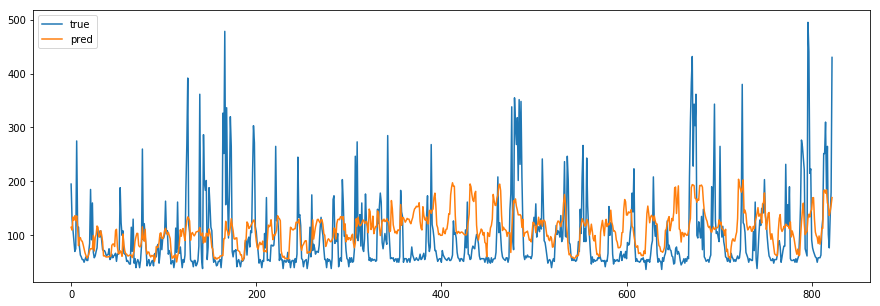

In [89]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(data_A_test['Appliances'].to_numpy(), label = "true")
plt.plot(data_A_pred_kn, label = "pred")
plt.legend()

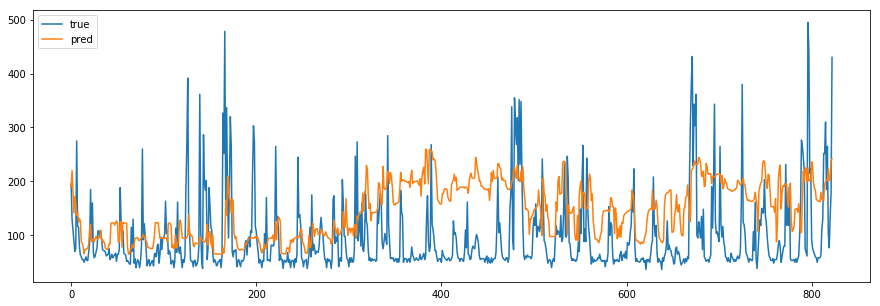

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(data_A_test['Appliances'].to_numpy(), label = "true")
plt.plot(data_A_pred_rf, label = "pred")
plt.legend()

# Sample small dataset

In [106]:
# Sampling settings
k = 10
l = int(0.1*N/k)
np.random.seed(10)
row_id = block_sampling(N, k, l)

data_B = data_A.iloc[row_id]

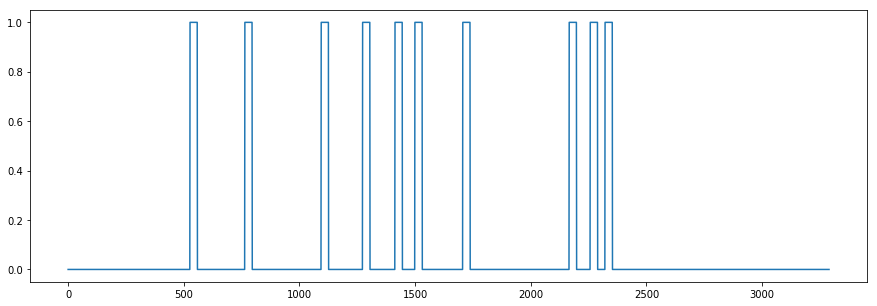

In [107]:
plt.plot(row_id)

## Fit on small dataset

In [108]:
n_train = int(0.75*len(data_B))
data_B_train = data_B.iloc[:n_train]
data_B_test = data_B.iloc[n_train:]

# Test on the samll data set
data_B_pred_kn, mse_kn, r2_kn, gs_kn = run_kn(X_train= data_B_train.loc[:, data_B_train.columns != 'Appliances'], Y_train = data_B_train.loc[:, 'Appliances'], X_test = data_B_test.loc[:, data_B_test.columns != 'Appliances'], Y_test = data_B_test.loc[:,'Appliances'])
print("KN: {}, {}".format(mse_kn, r2_kn))
data_B_pred_rf, mse_rf, r2_rf, gs_rf = run_rf(X_train= data_B_train.loc[:, data_B_train.columns != 'Appliances'], Y_train = data_B_train.loc[:, 'Appliances'], X_test = data_B_test.loc[:, data_B_test.columns != 'Appliances'], Y_test = data_B_test.loc[:,'Appliances'])
print("RF: {}, {}".format(mse_rf, r2_rf))

KN: 7027.6166461955145, -0.0169144889102133
RF: 6237.011236335474, 0.09748817941585652


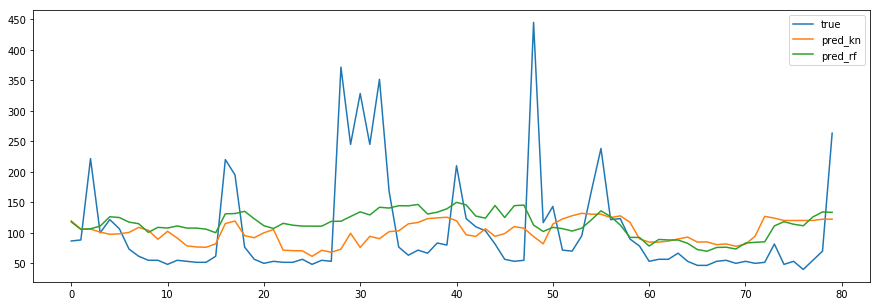

In [109]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(data_B_test['Appliances'].to_numpy(), label = "true")
plt.plot(data_B_pred_kn, label = "pred_kn")
plt.plot(data_B_pred_rf, label = "pred_rf")
plt.legend()

## Test on the full test set

In [110]:
# KNN
Y_test = data_A_test.loc[:,'Appliances']
Y_pred = gs_kn.predict(data_A_test.loc[:, data_A_test.columns != 'Appliances'])
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(mse, r2)

4559.834604040978 0.04516343761421471


In [112]:
# RF
Y_test = data_A_test.loc[:,'Appliances']
Y_pred = gs_rf.predict(data_A_test.loc[:, data_A_test.columns != 'Appliances'])
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(mse, r2)

5785.40814485837 -0.21147359602467874


### stupid predictor

In [113]:
data_B_pred_cst = data_B_train.loc[:,'Appliances'].mean()*np.ones(len(data_A_test))
mse = mean_squared_error(data_A_test.loc[:,'Appliances'], data_B_pred_cst)
r2 = r2_score(data_A_test.loc[:,'Appliances'], data_B_pred_cst)
print(mse, r2)

4882.690862938867 -0.022443172528530342
